# Figure 1 candidates

Here we want to show the relationship between our main variables. On one end, we want to explain the relationship of our treatments with the outcomes, this is showing how $\Delta$ NBR and FRP relates to CBI, but also how these relate to each other and with emissions from the inventories. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import rioxarray
from geocube.api.core import make_geocube

from prescribed.plot import run_fit_curve, template_plots

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

In [3]:
ca_geom = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/california_geom/datacalifornia_geom.shp"
).to_crs("EPSG:3310")

cbi = gpd.read_file("/mnt/sherlock/oak/prescribed_data/geoms/cbi_data/conus_cbi_v4.shp")
cbi = cbi.to_crs("EPSG:3310")

# Filter points inside ca_geom
cbi = cbi[cbi.geometry.within(ca_geom.geometry[0])]

# Add date
cbi["fire_date"] = pd.to_datetime(cbi["FireDate"], format="%m/%d/%Y")
cbi["fire_year"] = cbi["fire_date"].dt.year

In [4]:
land_type = (
    xr.open_dataset(
        "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.nc"
    )
    .to_array()
    .squeeze()
)

list_lt = []
for idx, row in cbi.iterrows():
    lt = land_type.sel(
        lon=row.geometry.centroid.x, lat=row.geometry.centroid.y, method="nearest"
    )

    vals = {"lat": lt.lat.values, "lon": lt.lon.values, "values": int(lt.values)}
    list_lt.append(vals)

cbi_land_type = pd.DataFrame(list_lt)

# Add land classes and names
cbi["land_type"] = cbi_land_type["values"].values
cbi["lat"] = cbi_land_type["lat"].values
cbi["lon"] = cbi_land_type["lon"].values

lc_labels = {
    1: "Agricultural",
    2: "Conifer",
    3: "Conifer-Hardwood",
    4: "Developed",
    5: "Exotic Herbaceous",
    6: "Exotic,Tree-Shrub",
    7: "Grassland",
    8: "Hardwood",
    9: "No Data",
    10: "Non-vegetated",
    11: "Riparian",
    12: "Shrubland",
    13: "Sparsely Vegetated",
}

cbi["land_type_name"] = cbi["land_type"].map(lc_labels)

In [5]:
nbr_cols = [c for c in cbi.columns if "NBR" in c]
cbi_col = ["Cbi"]

for var in nbr_cols + cbi_col:
    cbi[var] = cbi[var].apply(lambda x: float(x) if x != "NULL" else np.nan)

data = cbi[nbr_cols + ["land_type_name", "Cbi"]]
data.loc[:, "nbr_offset"] = data.loc[:, ("dNBR_val")] + data.loc[:, ("dNBR_off")]
data = data[data.land_type_name.isin(["Conifer", "Shrubland"])]

results = run_fit_curve(
    data,
    "Cbi",
    "nbr_offset",
    "land_type_name",
    cmap=["#1f78b4", "#b2df8a", "#33a02c", "#fb9a99"],
    ax=None,
    plot=False,
)

/tmp/ipykernel_410961/1539885025.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, "nbr_offset"] = data.loc[:, ("dNBR_val")] + data.loc[:, ("dNBR_off")]


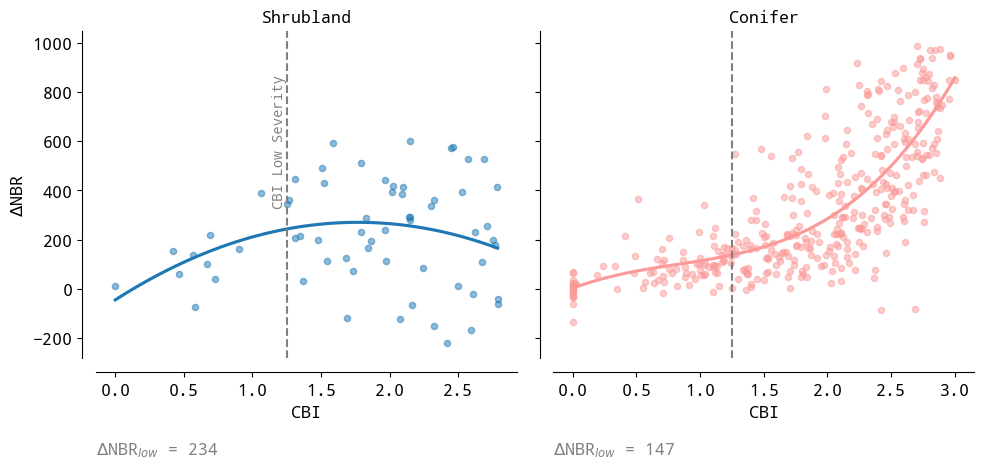

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

c_map = ["#1f78b4", "#fb9a99"]

# Plor CBI against dNBR_val by land type
for idx, (lt, col, ax) in enumerate(
    zip(data["land_type_name"].unique(), c_map, axs.flatten())
):
    data_lt = data[data["land_type_name"] == lt].dropna()
    data_lt.plot.scatter("Cbi", "nbr_offset", ax=ax, color=col, alpha=0.5)
    # Add regression line
    sns.regplot(
        x="Cbi",
        y="nbr_offset",
        data=data_lt,
        scatter=False,
        color=col,
        ax=ax,
        order=results[results["land_type_name"] == lt]["best_degree"]
        .astype(int)
        .values[0],
        ci=False,
    )

    # Add rounded dnbr_pred value as text on each ax
    ax.text(
        -0,
        -0.25,
        f"$\Delta$NBR$_{{low}}$ = {results[results['land_type_name'] == lt]['pred'].astype(int).values[0]}",
        transform=ax.transAxes,
        color="gray",
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
    )

    # Remove axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Add a subtitle to each ax
    ax.set_title(lt, fontsize=12)

    # Do a vertical line at 1.25
    ax.axvline(x=1.25, color="gray", linestyle="--")

    if idx == 0:
        # Add vertical text next to the line
        ax.text(
            1.20,
            600,
            "CBI Low Severity",
            color="gray",
            fontsize=10,
            rotation=90,
            verticalalignment="center",
            horizontalalignment="center",
        )

    # Change axis names
    ax.set_ylabel(r"$\Delta$NBR")
    ax.set_xlabel("CBI")

plt.tight_layout()
# plt.savefig("../figs/cbi_dnbr_land_types.png", dpi=300, bbox_inches="tight")

### CBI and MTBS with our dNBR

In [7]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [8]:
from geopandas import sjoin

# Merge with the MTBS event ids and match with dates
mtbs_cbi = sjoin(
    cbi,
    mtbs_ca[["Event_ID", "Ig_Date", "geometry", "year"]],
    how="inner",
)
mtbs_cbi = mtbs_cbi[mtbs_cbi.fire_year == mtbs_cbi.year]
mtbs_cbi.loc[:, "nbr_offset"] = (
    mtbs_cbi.loc[:, ("dNBR_val")] + mtbs_cbi.loc[:, ("dNBR_off")]
)

# Load FRP for each event and extract data
for idx, row in mtbs_cbi.iterrows():
    path_file = f"/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/{row['Event_ID']}.nc"

    if os.path.exists(path_file):
        dnbr_event = xr.open_dataset(path_file).to_dataarray().squeeze()
        dnbr_event = dnbr_event.sel(
            lat=row.geometry.centroid.y, lon=row.geometry.centroid.x, method="nearest"
        )
        mtbs_cbi.loc[idx, "frp"] = dnbr_event.values

In [9]:
template = xr.open_dataarray(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)
np.unique(
    make_geocube(vector_data=mtbs_cbi, measurements=["index_right"], like=template)
    .to_dataframe()
    .reset_index()
    .dropna()
    .index_right.values
).shape

(24,)

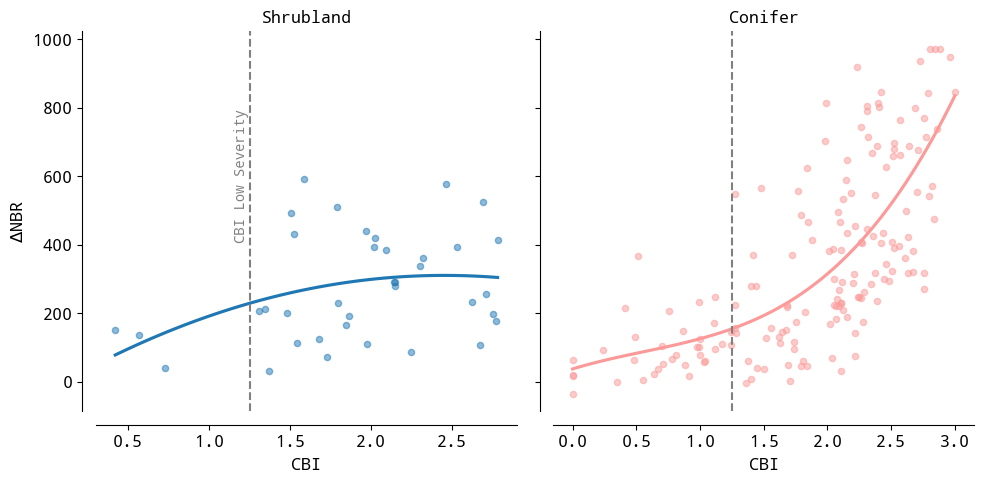

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

c_map = ["#1f78b4", "#fb9a99"]

# Plor CBI against dNBR_val by land type
for idx, (lt, col, ax) in enumerate(
    zip(mtbs_cbi["land_type_name"].unique(), c_map, axs.flatten())
):
    data_lt = mtbs_cbi[mtbs_cbi["land_type_name"] == lt].dropna()
    data_lt.plot.scatter("Cbi", "nbr_offset", ax=ax, color=col, alpha=0.5)
    # Add regression line
    sns.regplot(
        x="Cbi",
        y="nbr_offset",
        data=data_lt,
        scatter=False,
        color=col,
        ax=ax,
        order=results[results["land_type_name"] == lt]["best_degree"]
        .astype(int)
        .values[0],
        ci=False,
    )

    # Remove axis
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))

    # Add a subtitle to each ax
    ax.set_title(lt, fontsize=12)

    # Do a vertical line at 1.25
    ax.axvline(x=1.25, color="gray", linestyle="--")

    if idx == 0:
        # Add vertical text next to the line
        ax.text(
            1.20,
            600,
            "CBI Low Severity",
            color="gray",
            fontsize=10,
            rotation=90,
            verticalalignment="center",
            horizontalalignment="center",
        )

    # Change axis names
    ax.set_ylabel(r"$\Delta$NBR")
    ax.set_xlabel("CBI")

plt.tight_layout()
# plt.savefig("../figs/cbi_dnbr_land_types.png", dpi=300, bbox_inches="tight")

### Now all the things together!

In [11]:
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

In [12]:
# Intensity
frp = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/frp/frp_concat.feather"
)

# Severity
dnbr = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee_inmediate/dnbr_long.feather"
)
dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)
dnbr["dnbr"] = np.where(dnbr["dnbr"] < 0, 0, dnbr["dnbr"])

dnbr["prescribed"] = (
    dnbr["event_id"]
    .isin(mtbs_ca[mtbs_ca.Incid_Type == "Prescribed Fire"].Event_ID.tolist())
    .astype(np.int8)
)

# Emissions FINN
emissions_all = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_finn/finn_GEOSCHEM_mean.feather"
)
emissions_all["year"] = emissions_all["time"].dt.year

In [19]:
from prescribed.plot import data_fire_plot

event_id = "CA3966012280920200817"
fire = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=emissions_all,
    mtbs=mtbs_ca,
    year=2020,
    event_id=event_id,
)

fires = data_fire_plot(
    frp=frp,
    dnbr=dnbr,
    wide_treats="/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather",
    emissions=emissions_all,
    mtbs=mtbs_ca,
)

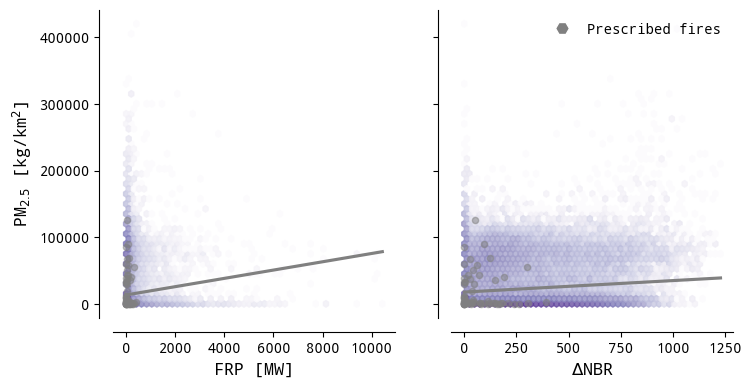

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax[0],
    alpha=0.8,
    gridsize=50,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax[0],
    alpha=0.5,
    color="gray",
)


# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax[0],
    ci=True,
    robust=False,
)
template_plots(ax[0], xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [kg/km$^2$]")

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax[1],
    alpha=0.8,
    gridsize=50,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax[1],
    alpha=0.5,
    color="gray",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax[1],
    ci=True,
    robust=False,
)
template_plots(ax[1], ylab="PM2.5", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax[1].legend(
    [
        plt.Line2D(
            [1], [0], marker="H", color="w", markerfacecolor="gray", markersize=10
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)

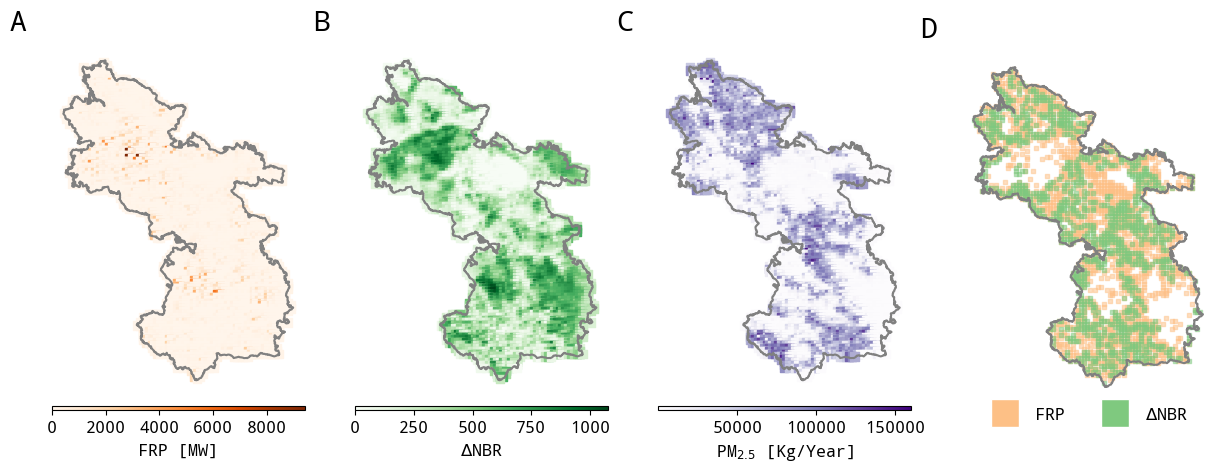

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Take care of the colorbar size
fig, ax = plt.subplots(1, 4, figsize=(15, 10))


divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[0], color="Grey")

# Plot with divergent color scheme
ax[0] = fire.plot(
    column="frp",
    legend=True,
    cmap="Oranges",
    marker=",",
    ax=ax[0],
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax[0], xlab="", ylab="", label="A", no_axis=True)


# Take care of the colorbar size
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="1%", pad=0.1)


mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[1], color="Grey")

# Plot with divergent color scheme
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Greens",
    ax=ax[1],
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax[1], xlab="", ylab="", label="B", no_axis=True)


# Plot emissions
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[2], color="Grey")

# Plot with divergent color scheme
ax[2] = fire.plot(
    column="PM25",
    legend=True,
    cmap="Purples",
    ax=ax[2],
    marker=",",
    cax=cax,
    legend_kwds={"label": r"PM$_{2.5}$ [Kg/Year]", "orientation": "horizontal"},
)
template_plots(ax[2], xlab="", ylab="", label="C", no_axis=True)

# Plot emissions
mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax[3], color="Grey")

# Plot with divergent color scheme
fire[fire.treat_intensity == 1].plot(
    marker=",", legend=False, ax=ax[3], color="#fdc086", alpha=0.5, markersize=8
)
# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax[3], color="#7fc97f", alpha=0.5, markersize=8
)

template_plots(ax[3], xlab="", ylab="", label="D", no_axis=True)

ax[3].legend(
    [
        plt.Line2D(
            [1], [0], marker="s", color="w", markerfacecolor="#fdc086", markersize=20
        ),
        plt.Line2D(
            [1], [10], marker="s", color="w", markerfacecolor="#7fc97f", markersize=20
        ),
    ],
    ["FRP", r"$\Delta$NBR"],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

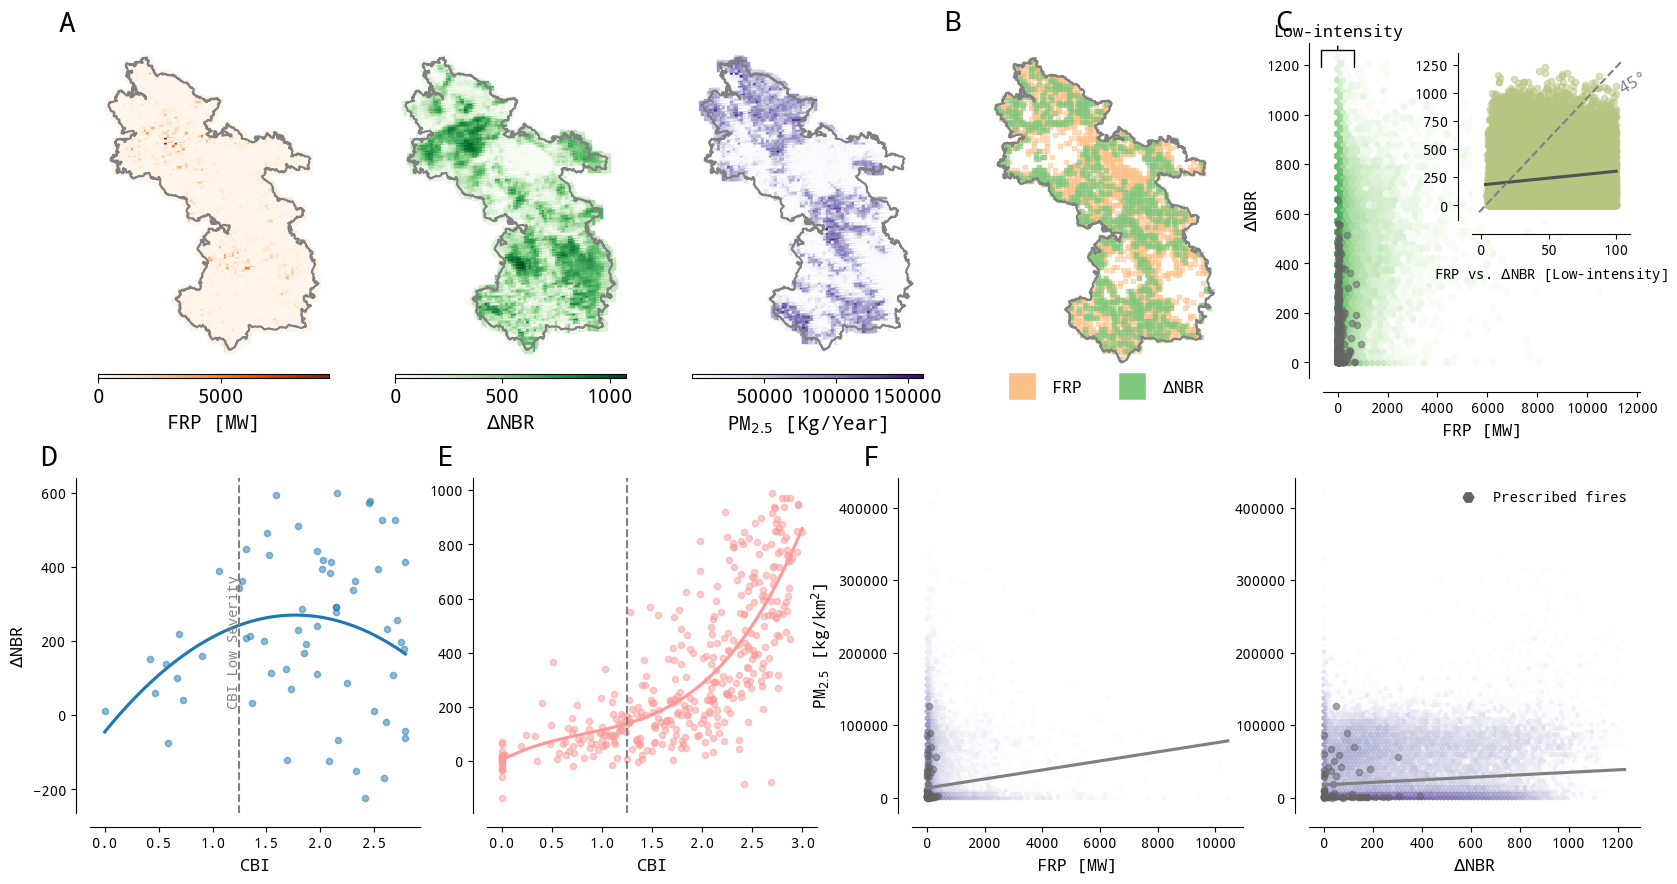

In [28]:
from matplotlib.gridspec import GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(2, 4, hspace=0.3, wspace=0.3)

################################################################################
############################# PLOT FIRE DYNAMICS MAPS ##########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 4, subplot_spec=spec[0, 0:-1])

# Plot FRP
ax = fig.add_subplot(subspec[0, 0])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="frp",
    legend=True,
    cmap="Oranges",
    marker=",",
    ax=ax,
    cax=cax,
    legend_kwds={"label": "FRP [MW]", "orientation": "horizontal"},
)

template_plots(ax, xlab="", ylab="", label="A", no_axis=True)

# Plot dNBR
ax = fig.add_subplot(subspec[0, 1])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="dnbr",
    legend=True,
    cmap="Greens",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"$\Delta$NBR", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot emissions
ax = fig.add_subplot(subspec[0, 2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="1%", pad=0.1)

mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")
fire.plot(
    column="PM25",
    legend=True,
    cmap="Purples",
    ax=ax,
    marker=",",
    cax=cax,
    legend_kwds={"label": r"PM$_{2.5}$ [Kg/Year]", "orientation": "horizontal"},
)
template_plots(ax, xlab="", ylab="", no_axis=True)

# Plot treatments
ax = fig.add_subplot(subspec[0, 3])
mtbs_ca[mtbs_ca.Event_ID == event_id].boundary.plot(ax=ax, color="Grey")

# Plot with divergent color scheme
fire[fire.treat_intensity == 1].plot(
    marker=",", legend=False, ax=ax, color="#fdc086", alpha=0.5, markersize=8
)
# Plot with divergent color scheme
fire[fire.treat_severity == 1].plot(
    marker=",", legend=False, ax=ax, color="#7fc97f", alpha=0.5, markersize=8
)

template_plots(ax, xlab="", ylab="", label="B", no_axis=True)

ax.legend(
    [
        plt.Line2D(
            [1], [0], marker="s", color="w", markerfacecolor="#fdc086", markersize=20
        ),
        plt.Line2D(
            [1], [10], marker="s", color="w", markerfacecolor="#7fc97f", markersize=20
        ),
    ],
    ["FRP", r"$\Delta$NBR"],
    fontsize=12,
    frameon=False,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=2,
)

################################################################################
########################### DNBR and FRP relationship ##########################
################################################################################

ax = fig.add_subplot(spec[0, -1])

# Create an inset plot to the main plot located to the top right
axins = inset_axes(ax, width="50%", height="50%", loc=1)

# Transform the data to plot a 2-d hexbin using matplotlib
fires.plot.hexbin(
    x="frp",
    y="dnbr",
    cmap="Greens",
    ax=ax,
    gridsize=50,
    bins="log",
    colorbar=False,
)

# Plot the prescribed fires in gray
fires[(fires["prescribed"] == 1)].plot.scatter(
    x="frp", y="dnbr", c="#636363", ax=ax, alpha=0.5, colorbar=False, fontsize=10
)

template_plots(ax, xlab="FRP [MW]", ylab=r"$\Delta$NBR", label="C")


# Insert an annotation with an arrowprop
ax.annotate(
    "Low-intensity",
    xy=(0, 1250),
    xytext=(0, 1300),
    ha="center",
    va="bottom",
    fontsize=12,
    arrowprops=dict(arrowstyle="-[, widthB=1.0, lengthB=1.0", lw=1, color="k"),
)

# Inlet plot
plt.rcParams.update({"font.size": 14})
fires[fires["treat_intensity"] == 1].plot.scatter(
    x="frp", y="dnbr", c="#B8C582", ax=axins, alpha=0.5, colorbar=False, fontsize=10
)

sns.regplot(
    x="frp",
    y="dnbr",
    data=fires[fires["treat_intensity"] == 1],
    scatter=False,
    ax=axins,
    color="#525252",
    robust=True,
)
template_plots(axins, xlab="", ylab="", diag=True)

# Add text in the same color over the 45-degree.
axins.text(100, 1000, "45°", rotation=28, color="gray", fontsize=12)
axins.set_title("FRP vs. $\Delta$NBR [Low-intensity]", fontsize=10, y=-0.4)

################################################################################
########################## CBI AND INTENSITY/SEVERITY ##########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[1, 0:2])

axs = [fig.add_subplot(subspec[0, 0]), fig.add_subplot(subspec[0, 1])]
c_map = ["#1f78b4", "#fb9a99"]
labs = ["D", "E"]
# Plor CBI against dNBR_val by land type
for idx, (lt, col, ax, lab) in enumerate(
    zip(data["land_type_name"].unique(), c_map, axs, labs)
):
    data_lt = data[data["land_type_name"] == lt].dropna()
    data_lt.plot.scatter("Cbi", "nbr_offset", ax=ax, color=col, alpha=0.5)
    # Add regression line
    sns.regplot(
        x="Cbi",
        y="nbr_offset",
        data=data_lt,
        scatter=False,
        color=col,
        ax=ax,
        order=results[results["land_type_name"] == lt]["best_degree"]
        .astype(int)
        .values[0],
        ci=False,
    )

    # Do a vertical line at 1.25
    ax.axvline(x=1.25, color="gray", linestyle="--")

    if idx == 0:
        # Add vertical text next to the line
        ax.text(
            1.20,
            200,
            "CBI Low Severity",
            color="gray",
            fontsize=10,
            rotation=90,
            verticalalignment="center",
            horizontalalignment="center",
        )
        template_plots(ax, xlab="CBI", ylab=r"$\Delta$NBR", label=lab)

    else:
        template_plots(ax, xlab="CBI", ylab="", label=lab)


################################################################################
####################### EMISSIONS AND INTENSITY/SEVERITY #######################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[1, 2:4])

ax = fig.add_subplot(subspec[0, 0])

fires.plot.hexbin(
    "frp",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in gray if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="frp",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=False,
)
template_plots(ax, xlab="FRP [MW]", ylab=r"PM$_{2.5}$ [kg/km$^2$]", label="F")

ax = fig.add_subplot(subspec[0, 1], sharey=ax)

fires.plot.hexbin(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.8,
    gridsize=80,
    bins="log",
    colorbar=False,
    cmap="Purples",
)

# Color hex in red if frp is less than 100
fires[fires.prescribed == 1].plot.scatter(
    "dnbr",
    "PM25",
    ax=ax,
    alpha=0.5,
    color="#636363",
)

# Add regression line w/ seaborn
sns.regplot(
    x="dnbr",
    y="PM25",
    data=fires,
    scatter=False,
    color="gray",
    ax=ax,
    ci=True,
    robust=False,
)

template_plots(ax, ylab="", xlab=r"$\Delta$NBR")

# Add a legend with a single red hexagon for the treatment
ax.legend(
    [
        plt.Line2D(
            [1], [0], marker="H", color="w", markerfacecolor="#636363", markersize=10
        ),
    ],
    ["Prescribed fires"],
    fontsize=10,
    frameon=False,
)
plt.savefig("../figs/potential_fig1.png", bbox_inches="tight", dpi=300)